In [15]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder
import lime
import lime.lime_tabular
import seaborn as sns
from LAdX import *

%pylab inline
plt.rcParams['figure.figsize'] = [10, 10]

Populating the interactive namespace from numpy and matplotlib


/Users/matt_rounds/miniconda2/envs/XA3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
X, y  = sklearn.datasets.make_moons(n_samples=10000, noise= 0.2)

In [17]:
## Train a back-box classifier on the synthetic dataset
import sklearn.model_selection, sklearn.ensemble

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)
print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.971
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       983
          1       0.97      0.98      0.97      1017

avg / total       0.97      0.97      0.97      2000



In [4]:
points = [np.array([-1., 1.]), np.array([-0.7,0.6]), np.array([-0.3,1.1]), np.array([1.5, 0.0]), np.array([0.,0.]), np.array([1., -0.5])]

In [5]:
explainer = lime.lime_tabular.LimeTabularExplainer(X, discretize_continuous = False)

In [6]:
def get_LIME_coeffs(points, explainer):
    output = []
    for i, point in enumerate(points):
        exp = explainer.explain_instance(point, clf.predict_proba, num_features=2, top_labels=1)
        class_ = clf.predict([point])
        intercept = list(exp.intercept.values())[0] #There's an irritating edge case where class_ =/= the class in the exp.
        coefs = [x[1] for x in sorted(exp.as_list(list(exp.intercept.keys())[0]), key=lambda x:x[0])]
        
        coefs.append(intercept)
        output.append(coefs)
        
    return output

In [7]:
C = get_LIME_coeffs(points,explainer)

In [8]:
pred_train = clf.predict(train) #Could pass soft output with predict_proba (note: you'll need to change loss to something like KLDivLoss)
pred_test = clf.predict(test)

pred_train = torch.from_numpy(pred_train).long()
pred_test = torch.from_numpy(pred_test).long()
train_t = torch.from_numpy(train).float()
test_t = torch.from_numpy(test).float()

In [9]:
scores, best_adv, best_top = LAX([train_t, pred_train, test_t, pred_test], 2)

[1, 1] loss: 0.5952557325363159
[1, 20] loss: 0.4556878164410591
[1, 40] loss: 0.37331248819828033
[1, 60] loss: 0.3612688258290291
[1, 80] loss: 0.3640248939394951
[1, 100] loss: 0.3556401148438454
[1, 120] loss: 0.37578071653842926
[1, 140] loss: 0.3574750259518623
[1, 160] loss: 0.38069445341825486
[1, 180] loss: 0.35715824365615845
[1, 200] loss: 0.3713539898395538
[1, 220] loss: 0.3564425423741341
[1, 240] loss: 0.35449291467666627
[1, 260] loss: 0.37721972167491913
[1, 280] loss: 0.33977019488811494
[1, 300] loss: 0.36181853264570235
[1, 320] loss: 0.3429598093032837
[1, 340] loss: 0.34955490529537203
[1, 360] loss: 0.3652372807264328
[1, 380] loss: 0.3634339705109596
[1, 400] loss: 0.37923285365104675
Train accuracy = 0.94875
[1, 400] loss: 0.3605982912214179
[1, 400] loss: 0.3481062199824896
[1, 400] loss: 0.34590884891606993
[1, 400] loss: 0.344046662502651
[1, 400] loss: 0.34293316440148786
Validation accuracy = 0.974
[2, 1] loss: 0.36883634328842163
[2, 20] loss: 0.354347413

[4, 240] n_loss: 0.3655941054224968
[4, 260] n_loss: 0.39386385679244995
[4, 280] n_loss: 0.3577432677149773
[4, 300] n_loss: 0.3663656830787659
[4, 320] n_loss: 0.3695905804634094
[4, 340] n_loss: 0.3665690317749977
[4, 360] n_loss: 0.3509738817811012
[4, 380] n_loss: 0.38665556013584135
[4, 400] n_loss: 0.37678791135549544
Adv train accuracy = 0.939
[4, 20] val n_loss: 0.3582799058211477
[4, 40] val n_loss: 0.34618316476161665
[4, 60] val n_loss: 0.35194186841027214
[4, 80] val n_loss: 0.35261677262149277
[4, 100] val n_loss: 0.3533235586652852
N-Validation accuracy = 0.9625
[5, 1] n_loss: 0.42112770676612854
[5, 20] n_loss: 0.39206704348325727
[5, 40] n_loss: 0.3748051255941391
[5, 60] n_loss: 0.3541236326098442
[5, 80] n_loss: 0.37711023092269896
[5, 100] n_loss: 0.3640489220619202
[5, 120] n_loss: 0.37867308408021927
[5, 140] n_loss: 0.3484438702464104
[5, 160] n_loss: 0.3665030270814896
[5, 180] n_loss: 0.366294164955616
[5, 200] n_loss: 0.364667983353138
[5, 220] n_loss: 0.36365

In [10]:
def get_crap_L2X_coeffs(points, pred_plus): #For the point itself
    coeffs = []
    points = torch.tensor(points)
    
    weights = pred_plus(points.float())
    
    for i in range(weights.shape[0]):
        
        point = points[i,:]
        weight = weights[i,:].double()
        cross_point1 = point.detach().numpy()
        
        weight=weight.detach().numpy() #For float-double issue reasons
        
        bias1 = 0.5 - weight[0]*cross_point1[0] - weight[1]*cross_point1[1]
        
        coeffs.append([weight[0], weight[1], bias1.item(0)])
    
    return coeffs

In [11]:
crap_coeffs = get_crap_L2X_coeffs(points,best_adv)

In [12]:
def rescale(vecs): #Assume batch x 2 dimension
    return np.divide(test, np.expand_dims(np.add(np.absolute(test[:,0]),np.absolute(test[:,1])),1))

In [13]:
def plot_2vec_field(points, pred, expl):
    lime_cs = np.array(get_LIME_coeffs(points, expl))
    l2x_cs = -pred(torch.tensor(points).float()).detach().numpy() # note minus for opposite of neg
    palette = sns.color_palette("bright", n_colors=2)

    f, axarr = plt.subplots(2,1)
    
    axarr[0].quiver(points[:,0],points[:,1],lime_cs[:,0],lime_cs[:,1],color = palette[0])
    axarr[1].quiver(points[:,0],points[:,1],l2x_cs[:,0],l2x_cs[:,1], color = palette[1])

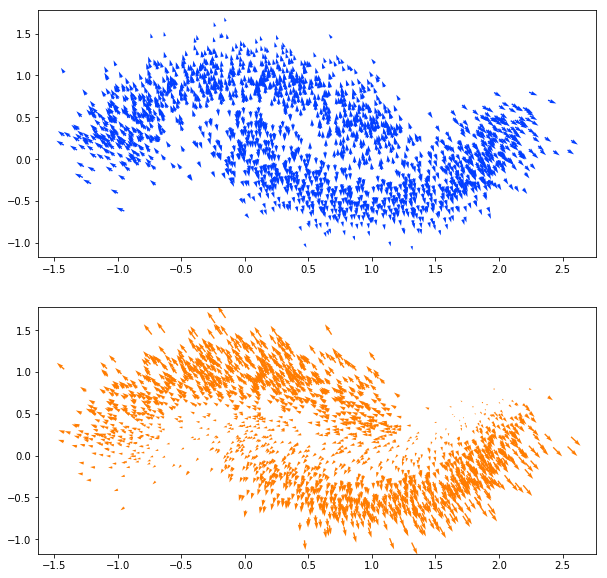

In [18]:
plot_2vec_field(test, best_adv, explainer)